In [1]:
import sys
print(sys.version)
%pwd

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]


'C:\\Users\\chrun\\Documents\\Projects\\Deep Learning\\structured data\\credit card fraud detection'

In [2]:
from fastai.structured import *
from fastai.column_data import *

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score, roc_auc_score, fbeta_score

pd.options.mode.chained_assignment = None

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
print(torch.__version__)

0.4.0


In [4]:
PATH = 'data/'

In [5]:
whole_data = pd.read_csv(PATH + 'creditcard.csv')

In [6]:
len(whole_data), len(whole_data[whole_data.Class > 0]), len(whole_data[whole_data.Class > 0]) / len(whole_data) * 100

(284807, 492, 0.1727485630620034)

In [7]:
whole_data['time'] = whole_data.Time.apply(lambda x: \
                     datetime.datetime.strptime('01/09/13 00:00:00', "%d/%m/%y %H:%M:%S") + datetime.timedelta(seconds=x))
whole_data.drop('Time', axis=1, inplace=True)

# split train test

In [8]:
test = whole_data.iloc[get_cv_idxs(len(whole_data), val_pct=0.2)]

In [9]:
train = whole_data.drop(test.index)

In [10]:
len(train), len(test)

(227846, 56961)

In [11]:
len(train[train.Class > 0]) / len(train) * 100, len(test[test.Class > 0]) / len(test) * 100

(0.1729238169640898, 0.17204754130018785)

In [12]:
add_datepart(train, 'time', drop=False, time=True)

In [13]:
add_datepart(test, 'time', drop=False, time=True)

In [14]:
for df in train, test:
    add_datepart(df, 'time', drop=False, time=True)
    singular = df.nunique(axis=0, dropna=False)    
    df.drop(singular[singular == 1].index.tolist() + ['timeElapsed'], axis=1, inplace=True)

In [15]:
len(train.columns), len(test.columns)

(39, 39)

In [16]:
excluded_cols = ['time', 'Class']

contin_cols = [f_ for f_ in train.columns if train[f_].dtype == 'float64']

cat_cols = [f_ for f_ in train.columns if( f_ not in excluded_cols) & (f_ not in contin_cols)]

In [17]:
len(cat_cols) + len(contin_cols), len(train.columns) - len(excluded_cols)

(37, 37)

In [18]:
dep = 'Class'
train_df = train[cat_cols + contin_cols + [dep, 'time']].copy()

In [19]:
test_df = test[cat_cols + contin_cols + [dep, 'time']].copy()

In [20]:
for v in cat_cols: train_df[v] = train_df[v].astype('category').cat.as_ordered()
apply_cats(test_df, train_df)

In [21]:
#imputer = Imputer()
#values = train_df[contin_vars].values
#train_df[contin_vars] = imputer.fit_transform(train_df[contin_vars])
#values = test_df[contin_vars].values
#test_df[contin_vars] = imputer.fit_transform(test_df[contin_vars])

for v in contin_cols:
    train_df[v] = train_df[v].fillna(0).astype('float32')
    test_df[v] = test_df[v].fillna(0).astype('float32')
    
train_df[dep] = train_df[dep].astype('int8')
test_df[dep] = test_df[dep].astype('int8')

In [22]:
train_indexed = train_df.set_index("time")

In [23]:
df, y, nas, mapper = proc_df(train_indexed, 'Class', do_scale=True)

In [24]:
test_indexed = test_df.set_index("time")

In [25]:
df_test, test_y, nas, mapper = proc_df(test_indexed, 'Class', do_scale=True, mapper=mapper, na_dict=nas)

In [26]:
len(train_indexed), len(test_indexed)

(227846, 56961)

In [27]:
samp_size = len(train_indexed)
train_ratio = 0.2
val_idx = get_cv_idxs(samp_size, val_pct=train_ratio)

In [28]:
len(df), len(val_idx), len(val_idx) / len(df) * 100

(227846, 45569, 19.999912221412707)

In [29]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_cols]

In [30]:
cat_sz

[('timeWeek', 3),
 ('timeDay', 3),
 ('timeDayofweek', 3),
 ('timeDayofyear', 3),
 ('timeIs_month_start', 3),
 ('timeHour', 25),
 ('timeMinute', 61),
 ('timeSecond', 61)]

In [31]:
emb_szs = [(c, max(10, min(50, (c+1)//2))) for _,c in cat_sz]

In [32]:
emb_szs

[(3, 10), (3, 10), (3, 10), (3, 10), (3, 10), (25, 13), (61, 31), (61, 31)]

In [33]:
import warnings; warnings.simplefilter('ignore')

In [34]:
#torch.manual_seed(40)
#random.seed(40)

In [35]:
#yl = np.log(y)
max_y = np.max(y)
y_range = (0, max_y*1.2)

In [36]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype('int64'), cat_flds=cat_cols, bs=64, 
                                       is_reg=False, is_multi=False, test_df=df_test)

In [37]:
m = md.get_learner(emb_szs=emb_szs, n_cont=(len(df.columns)-len(cat_cols)), emb_drop=0.04, out_sz=2, 
                   szs=[1000,500], drops=[0.001,0.01], y_range=y_range, use_bn=False, crit = F.cross_entropy)

In [38]:
m.crit

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [39]:
m.lr_find()

 39%|█████████████████████████▌                                       | 1121/2849 [00:12<00:18, 92.31it/s, loss=0.0486]

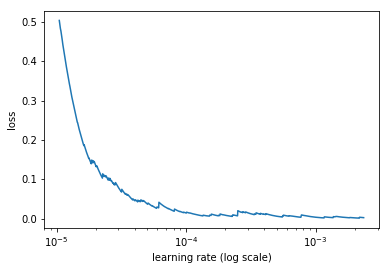

In [40]:
m.sched.plot()

In [41]:
lr = 1e-3 #0.0005

In [42]:
m.fit(lr, 1, cycle_len = 3, cycle_mult = 1, metrics=[accuracy]) #, f1, precision, recall

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.007513   0.00399    0.999451  
    1      0.002652   0.002981   0.999232                                                                              
    2      0.003268   0.002995   0.999429                                                                              


[0.0029948046929371406, 0.9994294366784436]

In [43]:
m.save("credit_fraud_3E") 

In [44]:
m.load("credit_fraud_3E")

In [45]:
m.fit(lr, 2, cycle_len = 2, cycle_mult = 2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.002719   0.003935   0.999342  
    1      0.001521   0.003937   0.999342                                                                              
    2      0.001683   0.005905   0.999407                                                                              
    3      0.000175   0.006832   0.999298                                                                              
    4      0.000494   0.006931   0.999298                                                                              
    5      0.00074    0.007619   0.999298                                                                              


[0.0076186015185135585, 0.999297768219623]

In [46]:
m.save("credit_fraud_3E6ER") 

In [47]:
m.load("credit_fraud_3E6ER") 

In [48]:
m.fit(lr, 1, cycle_len = 3, cycle_mult = 1, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.003176   0.010214   0.999342  
    1      9.6e-05    0.011015   0.999232                                                                              
    2      0.000287   0.010271   0.999254                                                                              


[0.010270628306507648, 0.9992538787333495]

In [49]:
m.save("credit_fraud_3E6ER3E")

In [50]:
m.load("credit_fraud_3E6ER3E")

In [51]:
m.fit(lr, 3, cycle_len = 3, cycle_mult = 1, metrics=[accuracy], best_save_name='credit_fraud_best')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.001006   0.014      0.999122  
    1      0.000285   0.012126   0.999298                                                                              
    2      0.000131   0.013659   0.999254                                                                              
    3      0.00034    0.012921   0.999232                                                                              
    4      0.000441   0.01374    0.99921                                                                               
    5      6.5e-05    0.013631   0.999254                                                                              
    6      0.001856   0.014967   0.9991                                                                                
    7      6.2e-05    0.015155   0.999122                                                                           

[0.01496587763553809, 0.9992319339902126]

In [52]:
m.load("credit_fraud_best")

# Test Set

In [53]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))

In [54]:
x_train,y_train = m.predict_with_targs()
x_train_torch = torch.from_numpy(x_train)
y_train_torch = torch.from_numpy(y_train)
accuracy(x_train_torch, y_train_torch)

tensor(0.9993)

In [55]:
x_train_torch = torch.max(x_train_torch, dim=1)[1]

In [56]:
len(x_train_torch[x_train_torch==1]), len(y_train_torch[y_train_torch == 1])

(66, 88)

In [57]:
print_results("Fastai NN classification train/validaton", y_train_torch.data.numpy(), x_train_torch.data.numpy())

Fastai NN classification train/validaton
accuracy: 0.999297768219623
precision: 0.9242424242424242
recall: 0.6931818181818182
f2: 0.729665071770335


### whole datepart

Fastai NN classification train/validaton
- accuracy: 0.9994294366784436
- precision: 0.9305555555555556
- recall: 0.7613636363636364
- f2: 0.7900943396226414

### selected datepart

Fastai NN classification train/validaton
- accuracy: 0.9995611051372644
- precision: 0.9594594594594594
- recall: 0.8068181818181818
- f2: 0.8333333333333334

In [58]:
x_test,_ = m.predict_with_targs(True)
x_test_torch = torch.from_numpy(x_test)
y_test_torch = torch.from_numpy(test_y.astype('int32')).long()
accuracy(x_test_torch,y_test_torch)

tensor(0.9994)

In [59]:
x_test_torch = torch.max(x_test_torch, dim=1)[1]

In [60]:
len(x_test_torch[x_test_torch == 1]), len(y_test_torch[y_test_torch == 1])

(85, 98)

In [61]:
print_results("Fastai NN classification test", y_test_torch, x_test_torch)

Fastai NN classification test
accuracy: 0.9993855444953564
precision: 0.8705882352941177
recall: 0.7551020408163265
f2: 0.7756813417190777


### whole datepart

Fastai NN classification test
- accuracy: 0.9995084355962852
- precision: 0.972972972972973
- recall: 0.7346938775510204
- f2: 0.7725321888412018

### selected datepart

Fastai NN classification test
- accuracy: 0.9995259914678464
- precision: 0.9493670886075949
- recall: 0.7653061224489796
- f2: 0.7961783439490445